In [1]:

# From now on we always have to use this line when using the dinoV3DeepLearn_py311 enviroment.
# When i installed matplotlib with conda, i got duplicate libomp.dll's, and that bricked the enviroment. so now we gotta allow duplicates.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch 


# Path to your local clone of the repo
REPO_DIR = r"C:\MyDocuments\GitHub\dinov3"

# Path to the downloaded checkpoint
CHECKPOINT_PATH = r"C:\MyDocuments\GitHub\dinov3\checkpoints\dinov3_vits16_pretrain_lvd1689m-08c60483.pth"

# Load the model
model = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights=CHECKPOINT_PATH)

model.eval()
print("Model loaded successfully!")





Model loaded successfully!


Features shape torch.Size([1, 256, 384])
Features other than patchtokens shape torch.Size([1, 261, 384])
tensor([[-0.2511,  0.0386,  0.3751,  ...,  0.5172, -0.6187, -0.4752],
        [-0.1942,  0.0522,  0.3681,  ...,  0.4544, -0.6367, -0.3558],
        [-0.1485,  0.0697,  0.3856,  ...,  0.3876, -0.6515, -0.3085],
        ...,
        [-0.1130, -0.0858, -0.1569,  ...,  0.1159, -0.4209, -0.2109],
        [-0.1243, -0.0529, -0.2877,  ...,  0.0972, -0.3897, -0.2958],
        [-0.1029,  0.0341, -0.0704,  ...,  0.2586, -0.4074, -0.2198]])


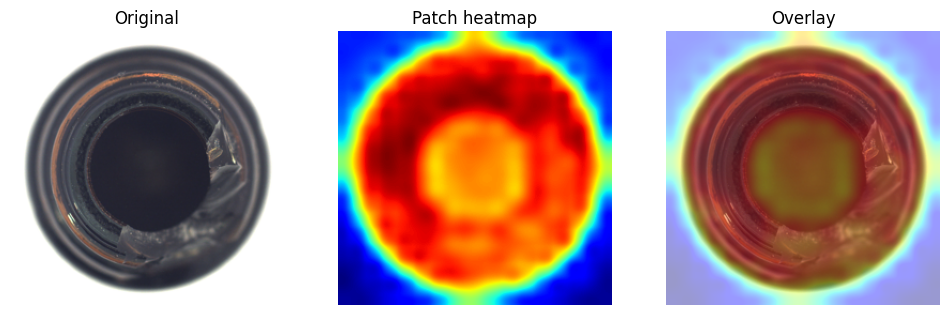

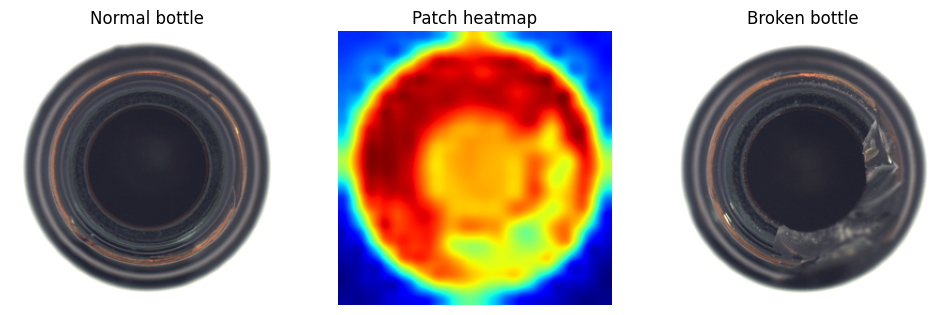

In [6]:
#Now try and extract some info from an image:
from torchvision import transforms
from PIL import Image
import os
from torchvision.transforms import v2
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


#Follow the github for preproccesing

def make_transform(resize_size: int = 256):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

pre_process = make_transform(resize_size = 256) #Could change size if we want


img_path = r".\bottle\train\good\000.png"
img_path1 = r".\bottle\test\broken_large\000.png" #Try a broken one
image = Image.open(img_path1).convert("RGB")
image_norm = Image.open(img_path).convert("RGB")
image_tensor = pre_process(image).unsqueeze(0)   # Add batch dim
image_tensor_normal = pre_process(Image.open(img_path).convert("RGB")).unsqueeze(0)

# Assuming 'model' is your DINOv3 model already loaded
model.eval()
with torch.no_grad():
    features_dict = model.forward_features(image_tensor)  # Usually outputs a tensor [1, 768] for vitb16
    #Also for the non-broken one
    features_dict_normal = model.forward_features(image_tensor_normal)



#Now we have a dictionary, with clstoken and a tensor. We only want the tensor.
features = features_dict["x_norm_patchtokens"]


print(f'Features shape {features.shape}')
print(f'Features other than patchtokens shape {features_dict["x_prenorm"].shape}')
print(features[0, :10])  # Print first 10 feature values

#Save as a np.array, and then resize it, and show it.
B, N, C = features.shape

# 2. Reshape [16, 16, 384]
H = W = int(N ** 0.5)
tokens_grid = features.reshape(1, H, W, C)

# 3. Turn each 384-d vector into a scalar (L2 norm)
#heatmap = torch.norm(tokens_grid, dim=-1)  # shape [1, 16, 16]
#Try the mean intead.
#heatmap = tokens_grid.mean(dim=-1)
#Try Variance
#heatmap = tokens_grid.var(dim=-1)

#Try similaitry to CLS tokens.
cls = features_dict["x_norm_clstoken"]  # [1,384]
cls = cls.expand_as(features[:, :N])

cls_norm = features_dict_normal["x_norm_clstoken"]
cls_norm = cls_norm.expand_as(features[:, :N])

#sim = torch.einsum("nc,nc->n", features.squeeze(0), cls.squeeze(0)) #Dot product for each patch vs. the global cls token.
#Try cosine similarity instead:
sim = F.cosine_similarity(
    features.squeeze(0), 
    cls.squeeze(0), 
    dim=-1
)

#Now try cosine similarity between cls tokens from a non-broken bottle, and patch tokens from a broken one.
sim_norm = F.cosine_similarity(
    features.squeeze(0),
    cls_norm.squeeze(0),
    dim =-1
)


heatmap = sim.reshape(H, W)

heatmap_cls_norm = sim_norm.reshape(H,W)

# 4. Normalize to [0, 1]
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

heatmap_cls_norm_norm = (heatmap_cls_norm - heatmap_cls_norm.min()) / (heatmap_cls_norm.max() - heatmap_cls_norm.min())

# 5. Upsample from 16×16 to 256×256 using PyTorch
heatmap_up = F.interpolate(
    heatmap_norm.unsqueeze(0).unsqueeze(0),  
    size=(256, 256),
    mode="bicubic",
    align_corners=False
)[0, 0].cpu().numpy()

#Vs. cls from normal bottle.
heatmap_up_cls_norm = F.interpolate(
    heatmap_cls_norm_norm.unsqueeze(0).unsqueeze(0),  
    size=(256, 256),
    mode="bicubic",
    align_corners=False
)[0, 0].cpu().numpy()


# 6. Convert original image to numpy (resize to 256)
image_np = np.array(image.resize((256, 256)))

#Also, print the normal pic.
image_norm_np = np.array(image_norm.resize((256, 256)))

# 7. Apply matplotlib colormap (jet)
colormap = plt.cm.jet
heatmap_color = colormap(heatmap_up)[:, :, :3]  # remove alpha channel
heatmap_color = (heatmap_color * 255).astype(np.uint8)

#Copy for the other picture.
colormap2 = plt.cm.jet
heatmap_color2 = colormap(heatmap_up_cls_norm)[:, :, :3]
heatmap_color2 = (heatmap_color2*255).astype(np.uint8)


# 8. Blend heatmap + image
overlay = (0.6 * image_np + 0.4 * heatmap_color).astype(np.uint8)

# 9. Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(image_np); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.show()

# 10. Visulatize second pic with normal cls_tokens
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Normal bottle"); plt.imshow(image_norm_np); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up_cls_norm, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Broken bottle"); plt.imshow(image_np); plt.axis("off")
plt.show()


